In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from itertools import permutations
import healpy as hp

from scipy import interpolate, ndimage,signal
from scipy.interpolate import SmoothSphereBivariateSpline
import scipy.fft as fft

from image_code import image_calculation_functions as ic


from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

%load_ext autoreload
%autoreload 2

In [544]:
theta_p = 181
phi_p = 361
phi = np.linspace(-180,180,phi_p)*np.pi/180
theta = np.linspace(0,90,int(theta_p/2)+1)*np.pi/180
P,T = np.meshgrid(phi,theta)



In [545]:
ra_list,dec_list,flux_0p6,flux_2,flux_10 = np.loadtxt('/data4/nmahesh/edges/Lunar/catalog/GLEAM_Scut-1Jyto28kJy-3freqs.txt',skiprows=1,usecols=(1,2,3,4,5),unpack=True)

In [4]:
far_array=np.load('/data4/nmahesh/edges/Lunar/array_layout/farside_array_nooffset.npy')

In [5]:

beam_squarel,ethetal, ephil=ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p1-1MHz_regolith-0',31,theta_p,phi_p)
beam_squarel90,ethetal90,ephil90=ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p1-1MHz_regolith-90',31,theta_p,phi_p)

beam_squareh,ethetah, ephih = ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p4-40MHz_regolith',10,theta_p,phi_p)
beam_squareh90,ethetah90,ephih90 = ic.read_feko('/data4/nmahesh/edges/Lunar/beam_files/dipole_0p4-40MHz_regolith-90',10,theta_p,phi_p)


In [1007]:

sample = 1

if sample==0:
    wav = 500 #in m; f = 0.6 MHz
    index = 17
    beam_square,etheta, ephi = beam_squarel,ethetal, ephil
    beam_square90,etheta90,ephi90 = beam_squarel90,ethetal90,ephil90
    flux_list = flux_0p6
    factor =150#*3
    
elif sample==1:
    wav = 150 # in m; f = 2MHz
    index = 3
    beam_square,etheta, ephi = beam_squareh,ethetah, ephih
    beam_square90,etheta90,ephi90=beam_squareh90,ethetah90,ephih90
    flux_list = flux_2
    factor =500#*3

elif sample==2:
    wav = 30 # in m; f = 10MHz
    index = 4
    beam_square,etheta, ephi = beam_squareh,ethetah, ephih
    beam_square90,etheta90,ephi90=beam_squareh90,ethetah90,ephih90
    flux_list = flux_10
    factor =2500#*3
    
f = 300/wav
####Normalizing by 2 MHz
l_grid = np.linspace(-1,1,int(factor))
m_grid = l_grid
L,M = np.meshgrid(l_grid,m_grid)

q = L**2+M**2
el = np.sqrt(1 - q)
el[q>=1] = 0
p =-np.arctan2(M,L) 
t = np.pi/2 - np.arcsin(el)#-np.arcsin(L,(np.sin(p)))+np.pi/2

etheta = np.roll(etheta[:,:,:-1],180,axis=2)/np.max(etheta[index,:,:])
etheta90 = np.roll(etheta90[:,:,:-1],180,axis=2)/np.max(etheta90[index,:,:])
ephi = np.roll(ephi[:,:,:-1],180,axis=2)/np.max(ephi[index,:,:])
ephi90 = np.roll(ephi90[:,:,:-1],180,axis=2)/np.max(ephi90[index,:,:])


ra_list_c = ra_list
dec_list_c = dec_list
flux_list_c = flux_list

<ipython-input-1007-1ef96bb5062b>:34: RuntimeWarning: invalid value encountered in sqrt
  el = np.sqrt(1 - q)


In [7]:
etheta[index,0,:]=0
etheta90[index,0,:]=0
ephi[index,0,:]=0
ephi90[index,0,:]=0

In [8]:
beam_etheta = ic.beam_interpolate(etheta[index],theta,phi[:-1],t,p)
beam_etheta90 = ic.beam_interpolate(etheta90[index],theta,phi[:-1],t,p)

beam_ephi = ic.beam_interpolate(ephi[index],theta,phi[:-1],t,p)
beam_ephi90 = ic.beam_interpolate(ephi90[index],theta,phi[:-1],t,p)



In [12]:
off = np.linspace(-12,12,24)*u.hour
cyg_a_altaz = np.zeros((len(off),2))
cyg_A = ic.processed_source()



for i in range(len(off)):
    cyg_A.init_skycoord('19 59 28.35645829 +40 44 02.0966496', Time.now()+off[i])
    cyg_a_altaz[i] = cyg_A.obj_a_altaz
    
time = Time.now()+off[13]
t2 = Time(time, scale='utc',location=('180d', '0d'))
lst = t2.sidereal_time('apparent').value
print(t2,lst)

2022-05-15 07:35:07.043802 11.119565066753315


In [546]:
sky_obj = ic.processed_source()
sky_obj.init_skycoords(ra_list_c,dec_list_c,flux_list_c,time)

In [547]:
sky_obj.tp_to_lm(30,l_grid,m_grid)

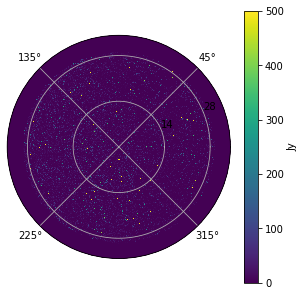

In [1146]:

fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,sky_obj.sky_map, rasterized= True, vmax =500)#,cmap = 'coolwarm')
ax.set_ylim([0,35*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')
ax.set_rgrids([0.25,0.5],[int(0.25*180/np.pi),int(0.5*180/np.pi)])
ax.grid()
ax.set_thetagrids([])
ax.set_xticks(np.array([45,135,225,315])*np.pi/180)
#plt.savefig('/data4/nmahesh/edges/Lunar/plots/gleam_sky_lm_30deg.pdf',bbox_inches='tight')#,dpi=200)

In [549]:
sky_obj.calculate_delphi(50,wav,L,M)

In [550]:
sky_obj.make_sky_stokes()

In [1008]:
def muller_cal_s(etheta_square,ephi_square,etheta_square90,ephi_square90,del_u,del_v,offset=0):
    M = np.zeros((4,4, np.shape(etheta_square)[0], np.shape(etheta_square)[1]),dtype='complex')
    
    phi = np.linspace(-180,180,361)*np.pi/180
    theta = np.linspace(0,90,91)*np.pi/180
    
    
    for i in range(len(theta)):
        for j in range(len(phi)-1):


            l = np.sin(theta[i])*np.cos(phi[j])
            m = np.sin(theta[i]) * np.sin(phi[j])                             
            del_phi = 2*np.pi* (del_u*l + del_v*m)
            J_b = np.array([[1,0],[0,np.exp(1j*del_phi)]])

            J = np.array([[etheta_square[i,j],ephi_square[i,j]],[etheta_square90[i,j],ephi_square90[i,j]]])
            if offset==1:
                J = np.dot(J_b,J)
            if offset ==2:
                J = J_b
            
            M[:,:,i,j] = 0.5 * np.dot(np.array([[1,0,0,1],[1,0,0,-1],[0,1,1,0],[0,-1j,1j,0]]) , np.kron(J,np.conj(J))).dot(np.array([[1,1,0,0],[0,0,1,1j],[0,0,1,-1j],[1,-1,0,0]]))
          
            
            #M[:,:,i,j] = np.kron(J,np.conj(J))
          
            #np.array([[1,0,0,1],[1,0,0,-1],[0,1,1,0],[0,-1j,1j,0]]) ,np.array([[1,1,0,0],[0,0,1,1j],[0,0,1,-1j],[1,-1,0,0]])
    return M

In [1009]:
M_rego_wavno1 = muller_cal_s(etheta[index,:,:],ephi[index,:,:],etheta90[index,:,:],ephi90[index,:,:],del_u,del_v,offset=0)
M_rego_wav1 = muller_cal_s(etheta[index,:,:],ephi[index,:,:],etheta90[index,:,:],ephi90[index,:,:],del_u,del_v,offset=1)

/home/nmahesh/miniconda3/envs/edges/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/nmahesh/miniconda3/envs/edges/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/nmahesh/miniconda3/envs/edges/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/nmahesh/miniconda3/envs/edges/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


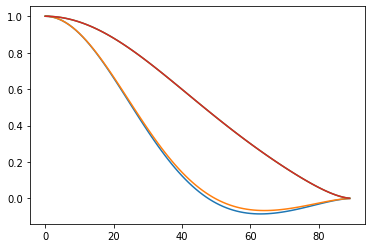

In [1020]:
plt.plot(M_rego_wav1[3,3,:90,0])
plt.plot(M_rego_wav1[3,3,:90,90])
plt.plot(M_rego_wavno1[3,3,:90,0])
plt.plot(M_rego_wavno1[3,3,:90,90])

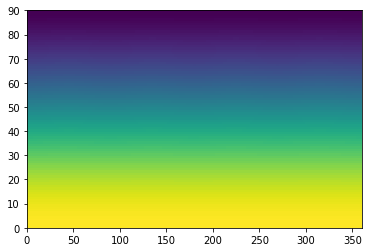

In [1026]:
plt.pcolormesh(np.abs(M_rego_wavno1[3,3,:90]))

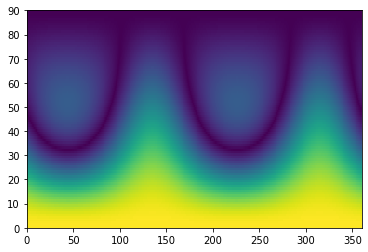

In [1025]:
plt.pcolormesh(np.abs(M_rego_wav1[3,3,:90]))

In [1027]:
M_lm = np.zeros((4,4,500,500),dtype='complex')
M_no_lm = np.zeros((4,4,500,500),dtype='complex')
for i in range(4):
    for j in range(4):
        M_lm[i,j,:,:] = ic.beam_interpolate(M_rego_wav1[i,j,:91,:360],theta,phi[:-1],t,p)
        M_no_lm[i,j,:,:] = ic.beam_interpolate(M_rego_wavno1[i,j,:91,:360],theta,phi[:-1],t,p)
    

In [1028]:
del_u,del_v,del_w = ic.uvcal(0,0,wav,50,50)
M_in = np.zeros((4,4, len(theta), len(phi)),dtype='complex')
del_phi = np.zeros_like(etheta[index])
phi = np.linspace(-180,180,361)*np.pi/180
theta = np.linspace(0,90,91)*np.pi/180
for i in range(len(theta)):
    for j in range(len(phi)-1):


        l = np.sin(theta[i])*np.cos(phi[j])
        m = np.sin(theta[i]) * np.sin(phi[j])                             
        del_phi[i,j] = 2*np.pi* (del_u*l + del_v*m)
        J = np.array([[1,0],[0,np.exp(1j*del_phi[i,j])]])

        M_in[:,:,i,j] = 0.5 * np.dot(np.array([[1,0,0,1],[1,0,0,-1],[0,1,1,0],[0,-1j,1j,0]]) , np.kron(np.linalg.inv(J),np.conj(np.linalg.inv(J)))).dot(np.array([[1,1,0,0],[0,0,1,1j],[0,0,1,-1j],[1,-1,0,0]]))
        #M_in[:,:,i,j] = 0.5 * np.dot(np.array([[1,1,0,0],[0,0,1,1j],[0,0,1,-1j],[1,-1,0,0]]), np.kron(np.conj(J),J)).dot(np.array([[1,0,0,1],[1,0,0,-1],[0,1,1,0],[0,-1j,1j,0]]) )


In [1029]:
M_off_lm = np.zeros_like(M_in_lm)
for i in range(4):
    for j in range(4):
        M_in_lm[i,j,:,:] = ic.beam_interpolate(M_in[i,j,:91,:360],theta,phi[:-1],t,p)
del_phi_lm = ic.beam_interpolate(del_phi[:91,:360],theta,phi[:-1],t,p)

In [556]:
vis = np.zeros((4,np.shape(sky_obj.sky_stokes)[0],np.shape(sky_obj.sky_stokes)[1]),dtype=np.complex128)  
vis_off = np.zeros((4,np.shape(sky_obj.sky_stokes)[0],np.shape(sky_obj.sky_stokes)[1]),dtype=np.complex128) 
for i in range(np.shape(sky_obj.sky_stokes)[0]):
    for j in range(np.shape(sky_obj.sky_stokes)[1]):     
        vis[:,i,j] = np.dot(M_no_lm[:,:,i,j],sky_obj.sky_stokes[i,j,:]) 
        vis_off[:,i,j] = np.dot(M_lm[:,:,i,j],sky_obj.sky_stokes[i,j,:]) 

In [557]:
vis_c_J = np.zeros_like(vis_off, dtype = np.complex128)
for i in range(factor):
    for j in range(factor):
        vis_c_J[:,i,j] = np.dot(M_in_lm[:,:,i,j],vis_off[:,i,j])

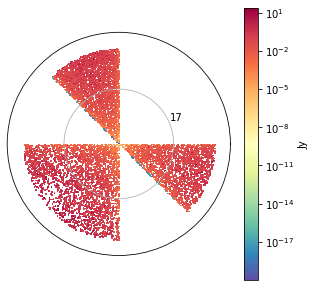

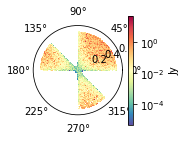

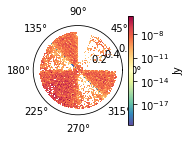

In [1050]:
fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
p1 =ax.pcolormesh(p,t,np.real(vis[3]-vis_off[3]),cmap='Spectral_r', rasterized= True, norm= LogNorm())
ax.set_ylim([0,35*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')
plt.rgrids([0.3],[int(0.3*180/np.pi)])
plt.grid()
plt.thetagrids([])

fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))
p1 =ax.pcolormesh(p,t,np.real(vis_off[3]),cmap='Spectral_r', rasterized= True, norm= LogNorm())
ax.set_ylim([0,35*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')

fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))
p1 =ax.pcolormesh(p,t,np.real(vis[3] - vis_c_J[3]),cmap='Spectral_r', rasterized= True, norm= LogNorm())#,vmin=10**-18, vmax = 10**4)
ax.set_ylim([0,35*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')


In [954]:
vis_clip = vis[:,250-125:250+125,250-125:250+125]
vis_clip_off = vis_off[:,250-125:250+125,250-125:250+125]

ft_beam_no = (fft.fftshift(fft.fft2(fft.fftshift(vis_clip))))
ft_beam_off = (fft.fftshift(fft.fft2(fft.fftshift(vis_clip_off))))


ft_sky = (fft.fftshift(fft.fft2(fft.fftshift(sky_obj.sky_stokes))))

ft_m_no = (fft.fftshift(fft.fft2(fft.fftshift(M_no_lm))))
ft_m_off = (fft.fftshift(fft.fft2(fft.fftshift(M_lm))))


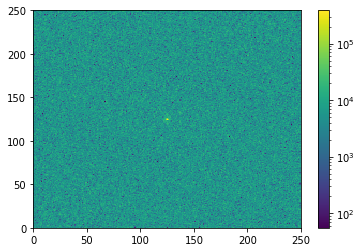

In [955]:
plt.pcolormesh(np.abs(ft_beam_no[0,:,:]),norm=LogNorm())
plt.colorbar()

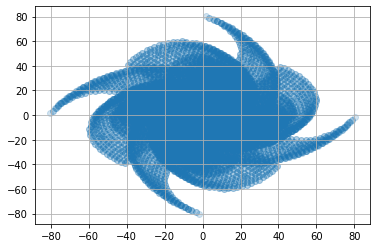

In [1151]:
sky_obj.uvcal(wav,far_array)
plt.scatter(sky_obj.u,sky_obj.v,alpha=0.2)
plt.grid()

In [641]:
x = np.linspace(-80,80,128)
y = x.T
b = np.repeat(x[:, np.newaxis], 128, axis=1)
c = np.repeat(y[np.newaxis, :], 128, axis=0)
sky_obj.u = b.flatten()
sky_obj.v = c.flatten()

In [642]:
np.shape(sky_obj.u)

(16384,)

In [774]:
factor = 2*24*3
H, xedges, yedges = np.histogram2d((sky_obj.u.flatten()),(sky_obj.v.flatten()),bins=(factor,factor),normed = True,range=[[-factor/np.pi,factor/np.pi],[-factor/np.pi,factor/np.pi]])

H_ftc = fft.ifftshift(fft.ifft2(fft.ifftshift(H)))*(factor/np.pi)**2

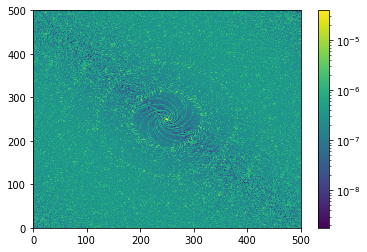

In [1147]:
plt.pcolormesh(np.abs(H_ft2),norm=LogNorm())
plt.colorbar()

In [807]:
factor = int(np.shape(sky_obj.del_phi)[0])
H, xedges, yedges = np.histogram2d((sky_obj.u.flatten()),(sky_obj.v.flatten()),bins=(factor,factor),normed = True,range=[[-factor/2,factor/2],[-factor/2,factor/2]])

H_ft = fft.ifftshift(fft.ifft2(fft.ifftshift(H)))*(factor)**2

In [1109]:
factor = int(np.shape(sky_obj.del_phi)[0])
H2, xedges, yedges = np.histogram2d((sky_obj.u.flatten()),(sky_obj.v.flatten()),bins=(factor,factor),normed = True,range=[[-80,80],[-80,80]])

H_ft2 = fft.ifftshift(fft.ifft2(fft.ifftshift(H2)))

In [888]:
factor = int(np.shape(sky_obj.del_phi)[0])
H3, xedges, yedges = np.histogram2d((sky_obj.u.flatten()),(sky_obj.v.flatten()),bins=(factor,factor),normed = True,range=[[-80,80],[-80,80]])

H_ft3 = fft.ifftshift(fft.ifft2(fft.ifftshift(H)))*(80)**2

/home/nmahesh/miniconda3/envs/edges/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


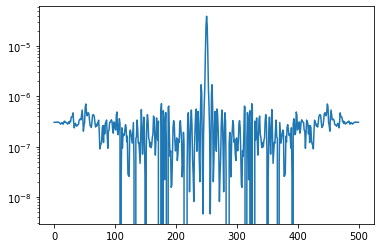

In [1115]:
#plt.plot(H_ft[:,250])
#plt.plot(H_ft2[1250:1750,1500])
plt.plot(H_ft2[:,250])
plt.yscale('log')

(125, 375)

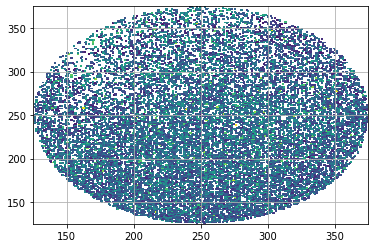

In [919]:
plt.pcolormesh(np.abs(vis[0]),norm=LogNorm())
plt.grid()
plt.ylim([250-125,250+125])
plt.xlim([250-125,250+125])

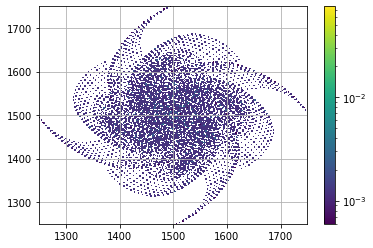

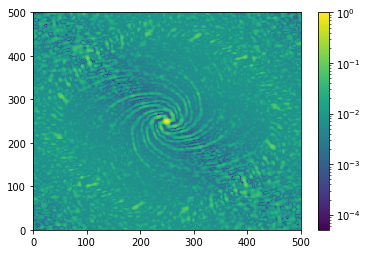

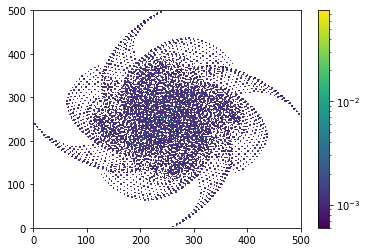

In [911]:
plt.figure()
plt.pcolormesh(np.abs(H2),norm=LogNorm())
plt.colorbar()
plt.xlim([1250,1750])
plt.ylim([1250,1750])

plt.grid()
plt.figure()
plt.pcolormesh(np.abs(H_ft),norm=LogNorm())
plt.colorbar()
plt.figure()
plt.pcolormesh(H3,norm=LogNorm())
plt.colorbar()


In [719]:
H_ft_clip = np.zeros_like(H_ft)
H_ft_clip[240:261,239:261] = H_ft[240:261,239:261]

In [959]:

vis_correct = np.zeros((4,factor,factor),dtype = np.complex128)
vis_correct_off = np.zeros((4,factor,factor),dtype = np.complex128)
sky_correct = np.zeros((4,factor,factor),dtype = np.complex128)
for i in range(4):
    #vis_correct[i] = signal.convolve2d(vis[i],H_ft2,mode='same')
    #vis_correct_off[i] = signal.convolve2d(vis_off[i],H_ft2,mode='same')
    sky_correct[i] = signal.convolve2d(sky_obj.sky_stokes[:,:,i],H_ft2,mode='same')

In [960]:
np.shape(sky_correct)

(4, 500, 500)

In [1032]:
vis_imag = np.zeros((4,np.shape(sky_obj.sky_stokes)[0],np.shape(sky_obj.sky_stokes)[1]),dtype=np.complex128)  
vis_imag_off = np.zeros((4,np.shape(sky_obj.sky_stokes)[0],np.shape(sky_obj.sky_stokes)[1]),dtype=np.complex128) 
for i in range(np.shape(sky_obj.sky_stokes)[0]):
    for j in range(np.shape(sky_obj.sky_stokes)[1]):     
        vis_imag[:,i,j] = np.dot(M_no_lm[:,:,i,j],sky_correct[:,i,j]) 
        vis_imag_off[:,i,j] = np.dot(M_lm[:,:,i,j],sky_correct[:,i,j]) 

In [817]:
ivis = np.zeros_like(beam_ft, dtype = np.complex128)
ivis_off = np.zeros_like(beam_ft, dtype = np.complex128)

for i in range(4):
    

        ivis[i] =   H*ft_beam_no[i]
        ivis_off[i] =H*ft_beam_off[i]

image_J = (fft.ifftshift(fft.ifft2(fft.ifftshift(ivis))))*(80)**2 
image_off_J = (fft.ifftshift(fft.ifft2(fft.ifftshift(ivis_off))))*(80)**2


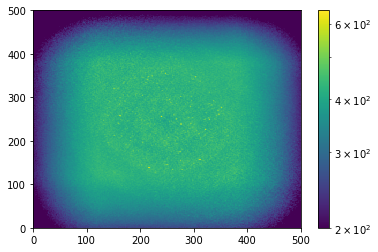

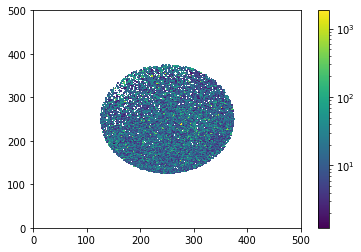

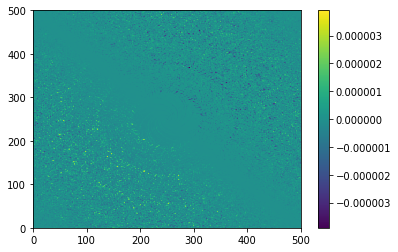

In [1122]:
plt.pcolormesh(np.abs(sky_correct[0]/2),norm=LogNorm(),vmin=200)
plt.colorbar()
plt.figure()
plt.pcolormesh(np.abs(sky_obj.sky_stokes[:,:,0]),norm=LogNorm())
plt.colorbar()

plt.figure()
plt.pcolormesh(np.imag(H_ft2))
plt.colorbar()

"\nplt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))\nplt.pcolormesh(p,t,np.abs(vis_imag[0]),norm=LogNorm(),cmap='coolwarm',vmin=5*10**2)\nplt.colorbar()\nplt.ylim([0,35*np.pi/180])\n\nplt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))\nplt.pcolormesh(p,t,np.abs(vis_imag_off[0]),norm=LogNorm(),cmap = 'coolwarm', vmin = 5*10**2)\nplt.colorbar()\nplt.ylim([0,35*np.pi/180])\n\n\nplt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))\nplt.pcolormesh(p,t,np.abs(image_c[0].T),norm=LogNorm(),cmap='coolwarm',vmin=500,vmax=1000)\nplt.colorbar()\nplt.ylim([0,35*np.pi/180])\n"

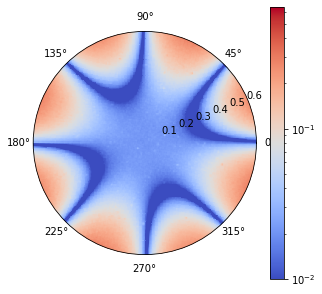

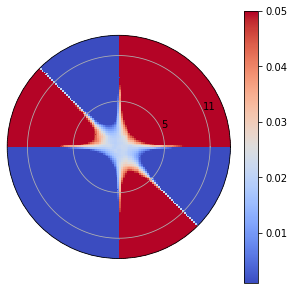

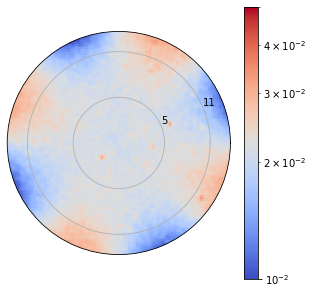

In [1177]:
plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
plt.pcolormesh(p,t,np.abs(vis_imag[3]),norm=LogNorm(),cmap='coolwarm',vmin=10**-2)
plt.colorbar()
plt.ylim([0,35*np.pi/180])

fig, ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
plt.pcolormesh(p,t,np.real(vis_imag_off[3]),cmap = 'coolwarm',vmin=0.001,vmax=0.05)
plt.colorbar()
ax.set_rgrids([0.1,0.2],[int(0.1*180/np.pi),int(0.2*180/np.pi)])
plt.grid()
ax.set_thetagrids([])
ax.set_ylim([0,14*np.pi/180])


fig, ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
plt.pcolormesh(p,t,np.real(image_c[3]),cmap='coolwarm',vmin=0.01,vmax=0.05,norm=LogNorm())
plt.colorbar()
ax.set_rgrids([0.1,0.2],[int(0.1*180/np.pi),int(0.2*180/np.pi)])
plt.grid()
ax.set_thetagrids([])
ax.set_ylim([0,14*np.pi/180])
'''
plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
plt.pcolormesh(p,t,np.abs(vis_imag[0]),norm=LogNorm(),cmap='coolwarm',vmin=5*10**2)
plt.colorbar()
plt.ylim([0,35*np.pi/180])

plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
plt.pcolormesh(p,t,np.abs(vis_imag_off[0]),norm=LogNorm(),cmap = 'coolwarm', vmin = 5*10**2)
plt.colorbar()
plt.ylim([0,35*np.pi/180])


plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
plt.pcolormesh(p,t,np.abs(image_c[0].T),norm=LogNorm(),cmap='coolwarm',vmin=500,vmax=1000)
plt.colorbar()
plt.ylim([0,35*np.pi/180])
'''

In [1035]:
image_c = np.zeros_like(image_J,dtype=np.complex256)
for i in range(factor):
    for j in range(factor):
        image_c[:,i,j] = np.dot(M_in_lm[:,:,i,j],vis_imag_off[:,i,j] )

In [1098]:
sky_pol = np.zeros_like(image_J, dtype = np.complex128)
sky_pol_off = np.zeros_like(image_J, dtype = np.complex128)
sky_pol_offc = np.zeros_like(image_J, dtype = np.complex128)

for i in range(factor):
    for j in range(factor):
        sky_pol[:,i,j] = vis_imag[:,i,j]# #[image[0],image[3]], np.dot(np.array([[1,0,0,1],[1,0,0,-1],[0,1,1,0],[0,-1j,1j,0]]),
        sky_pol_off[:,i,j] =vis_imag_off[:,i,j]##[image_off[0],image_off[3]] np.dot(np.array([[1,0,0,1],[1,0,0,-1],[0,1,1,0],[0,-1j,1j,0]]),
        sky_pol_offc[:,i,j] = image_c[:,i,j]#np.dot(np.array([[1,0,0,1],[1,0,0,-1],[0,1,1,0],[0,-1j,1j,0]]),image_c[:,i,j])  #[image_c[0],image_c[3]]

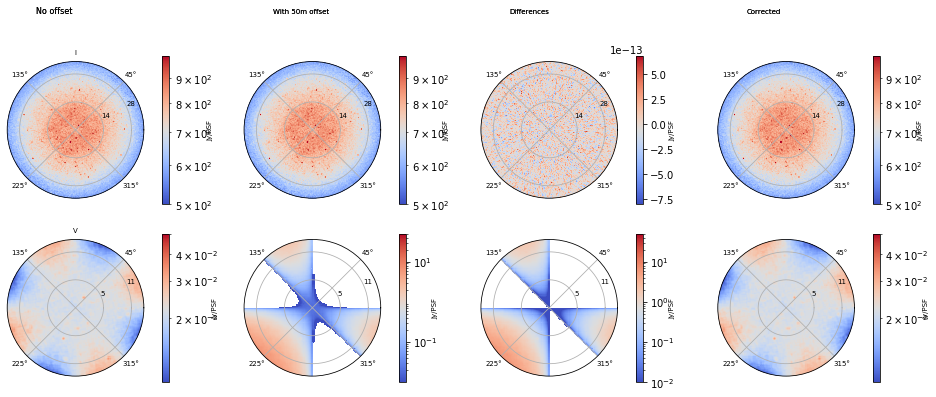

In [1186]:
              
#text = ['I', 'Q', 'U', 'V']
plt_no = 2
text = ['I','V']
fig2,ax2 = plt.subplots(plt_no,4, subplot_kw=dict(polar=True),figsize=(16,6))
plt.subplots_adjust(wspace=0.3,hspace=0.2)

#fig2.suptitle('Dipole beam on regolith @ '+ str(f)+'MHz',fontsize=14,y=1)

for i in range(plt_no):
    if i==0:
        p2 = ax2[int(i%plt_no),0].pcolormesh(p,t,np.real(sky_pol[3*i].T),cmap='coolwarm',rasterized = True,norm=LogNorm(),vmin=5*10**2, vmax = 1000)#,norm=LogNorm())#,)  
        ax2[int(i%plt_no),0].set_ylim([0,35*np.pi/180])
        ax2[int(i%plt_no),0].set_rgrids([0.25,0.5],[int(0.25*180/np.pi),int(0.5*180/np.pi)])

    else:
        p2 = ax2[int(i%plt_no),0].pcolormesh(p,t,np.real(sky_pol[3*i].T),cmap='coolwarm',rasterized = True, vmin=0.01,vmax=0.05,norm=LogNorm())#norm=LogNorm())#,vmin=vmin, vmax = vmax)#,norm=LogNorm())#,)  
        ax2[int(i%plt_no),0].set_ylim([0,14*np.pi/180])
        ax2[int(i%plt_no),0].set_rgrids([0.1,0.2],[int(0.1*180/np.pi),int(0.2*180/np.pi)])
    cbar = plt.colorbar(p2, ax=ax2[int(i%plt_no),0],pad=0.1,ticks=[1e-1,0,-1e-1]).set_label(label='Jy/PSF', size = 7,labelpad = -5)
    
    ax2[int(i%plt_no),0].grid()
    ax2[int(i%plt_no),0].set_thetagrids([])
    ax2[int(i%plt_no),0].tick_params(axis='both', labelsize=7)
    ax2[int(i%plt_no),0].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%plt_no),0].tick_params(axis='x',pad=-0.5)
    ax2[int(i%plt_no),0].set_title(text[i], pad=0.0, fontsize = 7)
    ax2[0,0].text(1.9,1.1,'No offset', fontsize=8)
    ax2[int(i%plt_no),0].set_rlabel_position(25)


###########################################################################################
    if i==0:
        p2 = ax2[int(i%plt_no),1].pcolormesh(p,t,np.real(sky_pol_off[3*i].T),cmap='coolwarm',rasterized = True,norm=LogNorm(),vmin=5*10**2, vmax = 1000)#,norm=LogNorm())#,)  
        ax2[int(i%plt_no),1].set_ylim([0,35*np.pi/180])
        ax2[int(i%plt_no),1].set_rgrids([0.25,0.5],[int(0.25*180/np.pi),int(0.5*180/np.pi)])
    else:
        p2 = ax2[int(i%plt_no),1].pcolormesh(p,t,np.real(sky_pol_off[3*i].T),cmap='coolwarm',rasterized = True, norm=LogNorm(),vmin=0.01, vmax =50)#,norm=LogNorm())#,vmin=vmin, vmax = vmax)#,norm=LogNorm())#,)  
        ax2[int(i%plt_no),1].set_ylim([0,14*np.pi/180])
        ax2[int(i%plt_no),1].set_rgrids([0.1,0.2],[int(0.1*180/np.pi),int(0.2*180/np.pi)])
    cbar = plt.colorbar(p2, ax=ax2[int(i%plt_no),1],pad=0.1,ticks=[1e1,1e-1,0,-1e-1,-1e1]).set_label(label='Jy/PSF', size = 7,labelpad = -5)
   
    ax2[int(i%plt_no),1].grid()
    ax2[int(i%plt_no),1].set_thetagrids([])
    ax2[int(i%plt_no),1].tick_params(axis='both', labelsize=7)
    
    ax2[int(i%plt_no),1].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%plt_no),1].tick_params(axis='x',pad=-0.5)
    ax2[0,1].text(1.9,1.1,'With 50m offset', fontsize=7)
    ax2[int(i%plt_no),1].set_rlabel_position(25)

#########################################################################################
    if i==0:
        p2 = ax2[int(i%plt_no),2].pcolormesh(p,t,np.real(sky_pol_off[3*i].T - sky_pol[3*i].T),cmap='coolwarm',rasterized = True)#,norm=LogNorm())#,vmin=0, vmax = 0.1)  
        ax2[int(i%plt_no),2].set_ylim([0,35*np.pi/180])
        ax2[int(i%plt_no),2].set_rgrids([0.25,0.5],[int(0.25*180/np.pi),int(0.5*180/np.pi)])

    else:
        p2 = ax2[int(i%plt_no),2].pcolormesh(p,t,np.real(sky_pol_off[3*i].T - sky_pol[3*i].T),cmap='coolwarm',rasterized = True,norm=LogNorm(),vmin=0.01, vmax = 50)#,vmin=0, vmax = 0.1)  
        ax2[int(i%plt_no),2].set_ylim([0,14*np.pi/180])
        ax2[int(i%plt_no),2].set_rgrids([0.1,0.2],[int(0.1*180/np.pi),int(0.2*180/np.pi)])


    cbar = plt.colorbar(p2, ax=ax2[int(i%plt_no),2],pad=0.1).set_label(label='Jy/PSF', size = 7,labelpad = -5)
    ax2[int(i%plt_no),2].grid()
    ax2[int(i%plt_no),2].set_thetagrids([])
    ax2[int(i%plt_no),2].tick_params(axis='both', labelsize=7)
    ax2[int(i%plt_no),2].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%plt_no),2].tick_params(axis='x',pad=-0.5)
    ax2[0,2].text(1.9,1.1,'Differences', fontsize=7)
    ax2[int(i%plt_no),2].set_rlabel_position(25)

#########################################################################################

    if i==0:
        p2 = ax2[int(i%plt_no),3].pcolormesh(p,t,np.real(image_c[3*i].T),cmap='coolwarm',rasterized = True,norm=LogNorm(),vmin=5*10**2, vmax = 1000)#,norm=LogNorm())#,)  
        ax2[int(i%plt_no),3].set_ylim([0,35*np.pi/180])
        ax2[int(i%plt_no),3].set_rgrids([0.25,0.5],[int(0.25*180/np.pi),int(0.5*180/np.pi)])

    else:
        p2 = ax2[int(i%plt_no),3].pcolormesh(p,t,np.real(image_c[3*i].T),cmap='coolwarm',rasterized = True,norm=LogNorm(),vmin=0.01, vmax = 0.05)#,norm=LogNorm())#,)  
        ax2[int(i%plt_no),3].set_ylim([0,14*np.pi/180])
        ax2[int(i%plt_no),3].set_rgrids([0.1,0.2],[int(0.1*180/np.pi),int(0.2*180/np.pi)])

    cbar = plt.colorbar(p2, ax=ax2[int(i%plt_no),3],pad=0.1,ticks=[1e-1,0,-1e-1]).set_label(label='Jy/PSF', size = 7,labelpad = -5)
     
    ax2[int(i%plt_no),3].grid()
    ax2[int(i%plt_no),3].set_thetagrids([])
    ax2[int(i%plt_no),3].tick_params(axis='both', labelsize=7)
    
    ax2[int(i%plt_no),3].set_xticks(np.array([45,135,225,315])*np.pi/180)
    ax2[int(i%plt_no),3].tick_params(axis='x',pad=-0.5)
    ax2[0,3].text(1.9,1.1,'Corrected', fontsize=7)
    ax2[int(i%plt_no),3].set_rlabel_position(25)

#plt.savefig('/data4/nmahesh/edges/Lunar/plots/plot_stokes_image_GLEAM_off_nooff_diff_2mhz_real_mull.pdf',dpi=200,bbox_inches='tight')



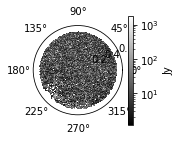

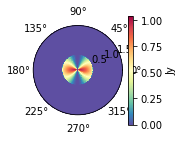

In [120]:
fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))
p1 =ax.pcolormesh(p,t,np.abs(temp[0]),cmap='gray', rasterized= True, norm= LogNorm())
ax.set_ylim([0,35*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')

fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))
p1 =ax.pcolormesh(p,t,np.abs(J_full_no_lm[0,0]),cmap='Spectral_r', rasterized= True)#, norm= LogNorm())
#ax.set_ylim([0,90*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')

In [ ]:

uv_correct = np.zeros((4,factor,factor),dtype = np.complex128)
uv_correct_off = np.zeros((4,factor,factor),dtype = np.complex128)
for i in range(4):
    uv_correct[i] = signal.convolve2d(H,ft_beam_no[i,0]+ft_beam_no[i,3],mode='same')
    uv_correct_off[i] = signal.convolve2d(H,ft_beam_off[i,0]+ft_beam_off[i,3],mode='same')

In [121]:
temp = np.zeros_like(vis_off_J,dtype=np.complex128)
for i in range(factor):
    for j in range(factor):
        temp[:,i,j] =np.dot(np.array([[1,1,0,0],[0,0,1,1j],[0,0,1,-1j],[1,-1,0,0]]),sky_obj.sky_stokes[i,j,:].T) 

ft_nooff_J = (fft.fftshift(fft.fft2(fft.fftshift(temp))))
ft_off_J = (fft.fftshift(fft.fft2(fft.fftshift(temp))))

ft_beam_no = (fft.fftshift(fft.fft2(fft.fftshift(J_full_no_lm))))
ft_beam_off = (fft.fftshift(fft.fft2(fft.fftshift(J_full_lm))))

#image_J = (fft.ifftshift(fft.ifft2(fft.ifftshift(ft_nooff_J))))*(factor/2)
#image_off_J = (fft.ifftshift(fft.ifft2(fft.ifftshift(ft_off_J))))*(factor/2)


'''        
fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))
p1 =ax.pcolormesh(p,t,np.real(image_J[2]),cmap='Spectral_r', rasterized= True, norm= LogNorm())
ax.set_ylim([0,35*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')

fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))
p1 =ax.pcolormesh(p,t,np.real(image_off_J[2]),cmap='Spectral_r', rasterized= True, norm= LogNorm())
ax.set_ylim([0,35*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')

fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))
p1 =ax.pcolormesh(p,t,np.real(image_c[2]),cmap='Spectral_r', rasterized= True, norm= LogNorm())#,vmin=10**-18, vmax = 10**4)
ax.set_ylim([0,35*np.pi/180])
plt.colorbar(p1, ax=ax,label='Jy')
'''

"        \nfig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))\np1 =ax.pcolormesh(p,t,np.real(image_J[2]),cmap='Spectral_r', rasterized= True, norm= LogNorm())\nax.set_ylim([0,35*np.pi/180])\nplt.colorbar(p1, ax=ax,label='Jy')\n\nfig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))\np1 =ax.pcolormesh(p,t,np.real(image_off_J[2]),cmap='Spectral_r', rasterized= True, norm= LogNorm())\nax.set_ylim([0,35*np.pi/180])\nplt.colorbar(p1, ax=ax,label='Jy')\n\nfig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(2,2))\np1 =ax.pcolormesh(p,t,np.real(image_c[2]),cmap='Spectral_r', rasterized= True, norm= LogNorm())#,vmin=10**-18, vmax = 10**4)\nax.set_ylim([0,35*np.pi/180])\nplt.colorbar(p1, ax=ax,label='Jy')\n"

In [125]:

uv_correct = np.zeros((4,factor,factor),dtype = np.complex128)
uv_correct_off = np.zeros((4,factor,factor),dtype = np.complex128)
for i in range(4):
    uv_correct[i] = signal.convolve2d(H,ft_beam_no[i,0]+ft_beam_no[i,3],mode='same')
    uv_correct_off[i] = signal.convolve2d(H,ft_beam_off[i,0]+ft_beam_off[i,3],mode='same')

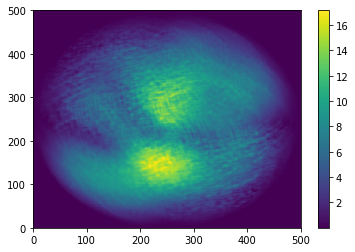

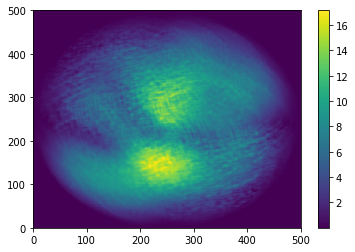

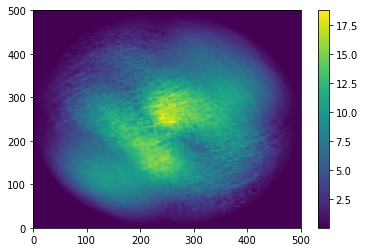

In [143]:
#fig,ax = plt.subplots(1,1, subplot_kw=dict(polar=True),figsize=(5,5))
plt.pcolormesh(np.abs(image_off_J[2]))#, norm = LogNorm())
#ax.set_ylim([0,30*np.pi/180])
plt.colorbar()
plt.figure()
plt.pcolormesh(np.abs(image_c[2]))#,norm=LogNorm())
plt.colorbar()
plt.figure()
plt.pcolormesh(np.abs(image_J[2]))#,norm=LogNorm())
plt.colorbar()

In [241]:
#etheta[index,31:,:] =0
#ephi[index,31:,:] =0
#etheta90[index,31:,:] =0
#ephi90[index,31:,:] =0

del_u,del_v,del_w = ic.uvcal(0,0,wav,50,50)
J_full = np.zeros((4,4, len(theta), len(phi)),dtype='complex')
J_full_no = np.zeros((4,4, len(theta), len(phi)),dtype='complex')
J_off_c = np.zeros((4,4, len(theta), len(phi)),dtype='complex')

phi = np.linspace(0,360,361)*np.pi/180
theta = np.linspace(0,90,91)*np.pi/180

for i in range(len(theta)):
    for j in range(len(phi)-1):


        l = np.sin(theta[i])*np.cos(phi[j])
        m = np.sin(theta[i]) * np.sin(phi[j])                             
        del_phi = 2*np.pi* (del_u*l + del_v*m)

        J_off = np.array([[1,0],[0,np.exp(1j*del_phi)]])
        J_beam = np.array([[etheta[index,i,j],ephi[index,i,j]],[etheta90[index,i,j],ephi90[index,i,j]]])
        J = np.dot(J_off, J_beam)
        
        J_full[:,:,i,j] = np.kron(J,np.conj(J))
        J_full_no[:,:,i,j] = np.kron(J_beam,np.conj(J_beam))
        J_off_c [:,:,i,j] = np.kron(np.conj(J_off),J_off)

In [214]:
J_full_lm = np.zeros((4,4,factor,factor),dtype = np.complex128)
J_full_no_lm = np.zeros((4,4,factor,factor),dtype = np.complex128)
J_off_c_lm = np.zeros((4,4,factor,factor),dtype = np.complex128)
for i in range(len(M_in_lm[:,0,0,0])):
    for j in range(len(M_in_lm[0,:,0,0])):
       
        #J_full_lm[i,j,:,:] = ic.beam_interpolate(J_full[i,j,:91,:360],theta,phi[:-1],t,p)
        J_full_no_lm[i,j,:,:] = ic.beam_interpolate(J_full_no[i,j,:91,:360],theta,phi[:-1],t,p)
        J_off_c_lm[i,j,:,:] = ic.beam_interpolate(J_off_c[i,j,:91,:360],theta,phi[:-1],t,p)

In [ ]:
vis_off_J = np.zeros((4,factor,factor),dtype = np.complex128)
vis_nooff_J = np.zeros((4,factor,factor),dtype = np.complex128)
vis_c_J = np.zeros((4,factor,factor),dtype = np.complex128)
#temp = np.zeros_like()
for i in range(factor):
    for j in range(factor):
        temp =np.dot(np.array([[1,1,0,0],[0,0,1,1j],[0,0,1,-1j],[1,-1,0,0]]),sky_obj.sky_stokes[i,j,:].T) 
        vis_off_J[:,i,j] = np.dot(J_full_lm[:,:,i,j],temp)
        vis_nooff_J[:,i,j] = np.dot(J_full_no_lm[:,:,i,j],temp)
        vis_c_J[:,i,j] = np.dot(J_off_c_lm[:,:,i,j],vis_off_J[:,i,j])